In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c chembl chembl_structure_pipeline
import chembl_structure_pipeline
from chembl_structure_pipeline import standardizer

In [1]:
from IPython.display import clear_output

# https://www.dgl.ai/pages/start.html

# !pip install dgl
!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html # FOR CUDA VERSION
!pip install dgllife
!pip install rdkit-pypi
!pip install --pre deepchem
!pip install ipython-autotime
!pip install gputil
!pip install psutil
!pip install humanize

%load_ext autotime

clear = clear_output()

time: 3.57 ms (started: 2021-11-30 14:18:54 +00:00)


In [2]:
import os
from os import path
import statistics
import warnings
import random
import time 
import itertools
import psutil
import humanize
import GPUtil as GPU
import subprocess
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import tqdm
from tqdm import trange, tqdm_notebook, tnrange

import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SumPooling, MaxPooling
import dgl.function as fn
import dgllife
from dgllife import utils

# embedding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.tensorboard import SummaryWriter


import sklearn
from sklearn.metrics import (auc, roc_curve, roc_auc_score, average_precision_score, 
                             accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, 
                             f1_score, PrecisionRecallDisplay)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore", message="DGLGraph.__len__")

DGLBACKEND = 'pytorch'

clear

def get_cmd_output(command):
  return subprocess.check_output(command,
                        stderr=subprocess.STDOUT,
                        shell=True).decode('UTF-8')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


time: 8.99 s (started: 2021-11-30 14:18:54 +00:00)


### Create Dataset

In [3]:
def create_dataset(df, name, bonds):
    print(f"Creating Dataset and Saving to {drive_path}/data/{name}.pkl")
    data = df.sample(frac=1)
    data = data.reset_index(drop=True)
    data['mol'] = data['smiles'].apply(lambda x: create_dgl_features(x, bonds))
    data.to_pickle(f"{drive_path}/data/{name}.pkl")
    return data

def featurize_atoms(mol):
  feats = []
  
  atom_features = utils.ConcatFeaturizer([
    utils.atom_type_one_hot,
    utils.atomic_number_one_hot,
    utils.atom_degree_one_hot,
    utils.atom_explicit_valence_one_hot,
    utils.atom_formal_charge_one_hot,
    utils.atom_num_radical_electrons_one_hot,
    utils.atom_hybridization_one_hot,
    utils.atom_is_aromatic_one_hot
  ])

  for atom in mol.GetAtoms():
    feats.append(atom_features(atom))
  return {'feats': torch.tensor(feats).float()}

def featurize_bonds(mol):
  feats = []
  
  bond_features = utils.ConcatFeaturizer([
    utils.bond_type_one_hot,
    utils.bond_is_conjugated_one_hot,
    utils.bond_is_in_ring_one_hot,
    utils.bond_stereo_one_hot,
    utils.bond_direction_one_hot,
  ])

  for bond in mol.GetBonds():
    feats.append(bond_features(bond))
    feats.append(bond_features(bond))
  return {'edge_feats': torch.tensor(feats).float()}

def create_dgl_features(smiles, bonds):
    mol = Chem.MolFromSmiles(smiles)
    mol = standardizer.standardize_mol(mol)
    
    if bonds:
        dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    edge_featurizer=featurize_bonds,
                                    canonical_atom_order=True)
    else:
      dgl_graph = utils.mol_to_bigraph(mol=mol,
                                    node_featurizer=featurize_atoms,
                                    canonical_atom_order=True)
    
    dgl_graph = dgl.add_self_loop(dgl_graph)
    
    return dgl_graph

def load_dataset(dataset, bonds=False, feat='graph', create_new=False):
  """
    dataset values: muv, tox21, dude-gpcr
    feat values: graph, ecfp
  """
  dataset_test_tasks = {
    'tox21': ['SR-HSE', 'SR-MMP', 'SR-p53'],
    'muv': ['MUV-832', 'MUV-846', 'MUV-852', 'MUV-858', 'MUV-859'],
    'dude-gpcr': ['adrb2', 'cxcr4']
  }

  dataset_original = dataset

  if bonds:
    dataset = dataset + "_with_bonds"

  if path.exists(f"{drive_path}/data/{dataset}_dgl.pkl") and not create_new:
    # Load Dataset
    print("Reading Pickle")
    if feat == 'graph':
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_dgl.pkl")
    else:
      data = pd.read_pickle(f"{drive_path}/data/{dataset}_ecfp.pkl")
  else:
    # Create Dataset
    df = pd.read_csv(f"{drive_path}/data/raw/{dataset_original}.csv")
    if feat == 'graph':
      data = create_dataset(df, f"{dataset}_dgl", bonds)
    else:
      data = create_ecfp_dataset(df, f"{dataset}_ecfp")

  test_tasks = dataset_test_tasks.get(dataset_original)
  drop_cols = test_tasks.copy()
  drop_cols.extend(['mol_id', 'smiles', 'mol'])
  train_tasks = [x for x in list(data.columns) if x not in drop_cols]

  train_dfs = dict.fromkeys(train_tasks)
  for task in train_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']
      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)
      train_dfs[task] = df
  for key in train_dfs:
    print(key, len(train_dfs[key]))

  if feat == 'graph':
    feat_length = data.iloc[0].mol.ndata['feats'].shape[-1]
    print("Feature Length", feat_length)

    if with_bonds:
      feat_length = data.iloc[0].mol.edata['edge_feats'].shape[-1]
      print("Feature Length", feat_length)
    else:
      print("Edge Features: ", with_bonds)

  test_dfs = dict.fromkeys(test_tasks)

  for task in test_tasks:
      df = data[[task, 'mol']].dropna()
      df.columns = ['y', 'mol']

      # FOR BOND INFORMATION
      if with_bonds:
        for index, r in df.iterrows():
          if r.mol.edata['edge_feats'].shape[-1] < 17:
            df.drop(index, inplace=True)

      test_dfs[task] = df

  for key in test_dfs:
    print(key, len(test_dfs[key]))

  # return data, train_tasks, test_tasks
  return train_tasks, train_dfs, test_tasks, test_dfs

time: 166 ms (started: 2021-11-30 14:19:03 +00:00)


## Create Episode

In [4]:
def create_episode(n_support_pos, n_support_neg, n_query, data, test=False, train_balanced=True):
  """
    n_query = per class data points
    Xy = dataframe dataset in format [['y', 'mol']]
  """
  support = []
  query = []

  n_query_pos = n_query
  n_query_neg = n_query

  support_neg = data[data['y'] == 0].sample(n_support_neg)
  support_pos = data[data['y'] == 1].sample(n_support_pos)

  # organise support by class in array dimensions
  support.append(support_neg.to_numpy())
  support.append(support_pos.to_numpy())
  support = np.array(support, dtype=object)
  support_X = [rec[1] for sup_class in support for rec in sup_class]
  support_y = np.asarray([rec[0] for sup_class in support for rec in sup_class], dtype=np.float16).flatten()

  data = data.drop(support_neg.index)
  data = data.drop(support_pos.index)

  if len(data[data['y'] == 1]) < n_query:
    n_query_pos = len(data[data['y'] == 1])

  if test:
    # test uses all data remaining
    query_neg = data[data['y'] == 0].to_numpy()
    query_pos = data[data['y'] == 1].to_numpy()
  elif (not test) and train_balanced:
    # for balanced queries, same size as support
    query_neg = data[data['y'] == 0].sample(n_query_neg).to_numpy()
    query_pos = data[data['y'] == 1].sample(n_query_pos).to_numpy()
  elif (not test) and (not train_balanced):
    # print('test')
    query_neg = data[data['y'] == 0].sample(1).to_numpy()
    query_pos = data[data['y'] == 1].sample(1).to_numpy()

    query_rem = data.sample(n_query*2 - 2)
    query_neg_rem = query_rem[query_rem['y'] == 0].to_numpy()
    query_pos_rem = query_rem[query_rem['y'] == 1].to_numpy()

    query_neg = np.concatenate((query_neg, query_neg_rem))
    query_pos = np.concatenate((query_pos, query_pos_rem), axis=0)

  query_X = np.concatenate([query_neg[:, 1], query_pos[:, 1]])
  query_y = np.concatenate([query_neg[:, 0], query_pos[:, 0]])
  
  return support_X, support_y, query_X, query_y

time: 35.9 ms (started: 2021-11-30 14:19:04 +00:00)


In [5]:
# task = 'NR-AR'
# df = data[[task, 'mol']]
# df = df.dropna()
# df.columns = ['y', 'mol']

# support_X, support_y, query_X, query_y = create_episode(1, 1, 64, df)

# support_y


# testing
# support = []
# query = []

# support_neg = df[df['y'] == 0].sample(2)
# support_pos = df[df['y'] == 1].sample(2)

# # organise support by class in array dimensions
# support.append(support_neg.to_numpy())
# support.append(support_pos.to_numpy())
# support = np.array(support)
# support.shape

# support[:, :, 1]


time: 3.04 ms (started: 2021-11-30 14:19:04 +00:00)


## Graph Embedding

In [6]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels=128):
      super(GCN, self).__init__()
      self.conv1 = GraphConv(in_channels, 64)
      self.conv2 = GraphConv(64, 128)
      self.conv3 = GraphConv(128, 64)
      self.sum_pool = SumPooling()
      self.dense = nn.Linear(64, out_channels)

    def forward(self, graph, in_feat):
        h = self.conv1(graph, in_feat)
        h = F.relu(h)
        graph.ndata['h'] = h       
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))
      
        h = self.conv2(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        h = self.conv3(graph, graph.ndata['h'])
        h = F.relu(h)
        graph.ndata['h'] = h
        graph.update_all(fn.copy_u('h', 'm'), fn.max('m', 'h'))

        output = self.sum_pool(graph, graph.ndata['h'])
        output = torch.tanh(output)
        output = self.dense(output)
        output = torch.tanh(output)
        return output

time: 20.8 ms (started: 2021-11-30 14:19:04 +00:00)


## Distance Function

In [7]:
def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

time: 5.58 ms (started: 2021-11-30 14:19:04 +00:00)


### LSTM

In [8]:
def cos(x, y):
  transpose_shape = tuple(list(range(len(y.shape)))[::-1])

  x = x.float()

  denom = (
      torch.sqrt(torch.sum(torch.square(x)) *
                     torch.sum(torch.square(y))) + torch.finfo(torch.float32).eps)

  return torch.matmul(x, torch.permute(y, transpose_shape)) / denom

class ResiLSTMEmbedding(nn.Module):
  def __init__(self, n_support, n_feat=128, max_depth=3):
    super(ResiLSTMEmbedding, self).__init__()

    self.max_depth = max_depth
    self.n_support = n_support
    self.n_feat = n_feat


    self.support_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)
    self.q_init = torch.nn.Parameter(torch.zeros((self.n_support, self.n_feat), dtype=torch.float, device="cuda"))
    self.support_states_init_h = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
    self.support_states_init_c = torch.nn.Parameter(torch.zeros(self.n_support, self.n_feat))
  
    self.query_lstm = nn.LSTMCell(input_size=2*self.n_feat, hidden_size=self.n_feat)

    if torch.cuda.is_available():
      self.support_lstm = self.support_lstm.cuda()
      self.query_lstm = self.query_lstm.cuda()
      self.q_init = self.q_init.cuda()
      # self.p_init = self.p_init.cuda()
  
  def forward(self, x_support, x_query):
    self.p_init = torch.zeros((len(x_query), self.n_feat)).to(device)
    self.query_states_init_h = torch.zeros(len(x_query), self.n_feat).to(device)
    self.query_states_init_c = torch.zeros(len(x_query), self.n_feat).to(device)

    x_support = x_support
    x_query = x_query
    z_support = x_support
    q = self.q_init
    p = self.p_init
    support_states_h = self.support_states_init_h
    support_states_c = self.support_states_init_c
    query_states_h = self.query_states_init_h
    query_states_c = self.query_states_init_c

    for i in range(self.max_depth):
      sup_e = cos(z_support + q, x_support)
      sup_a = torch.nn.functional.softmax(sup_e, dim=-1)
      sup_r = torch.matmul(sup_a, x_support).float()

      query_e = cos(x_query + p, z_support)
      query_a = torch.nn.functional.softmax(query_e, dim=-1)
      query_r = torch.matmul(query_a, z_support).float()

      sup_qr = torch.cat((q, sup_r), 1)
      support_hidden, support_out = self.support_lstm(sup_qr, (support_states_h, support_states_c))
      q = support_hidden

      query_pr = torch.cat((p, query_r), 1)
      query_hidden, query_out = self.query_lstm(query_pr, (query_states_h, query_states_c))
      p = query_hidden

      z_support = sup_r

    return x_support + q, x_query + p

time: 79.4 ms (started: 2021-11-30 14:19:04 +00:00)


## Protonet


https://colab.research.google.com/drive/1QDYIwg2-iiUpVU8YyAh0lOgFgFPhVgvx#scrollTo=BnLOgECOKG_y

In [9]:
class ProtoNet(nn.Module):
  def __init__(self, with_bonds=False):
    """
    Prototypical Network
    """
    super(ProtoNet, self).__init__()

  def forward(self, X_support, X_query, n_support_pos, n_support_neg):

    n_support = len(X_support)
    
    # prototypes
    z_dim = X_support.size(-1) # size of the embedding - 128
    z_proto_0 = X_support[:n_support_neg].view(n_support_neg, z_dim).mean(0)
    z_proto_1 = X_support[n_support_neg:n_support].view(n_support_pos, z_dim).mean(0)
    z_proto = torch.stack((z_proto_0, z_proto_1))

    # queries
    z_query = X_query

    # compute distance
    dists = euclidean_dist(z_query, z_proto) # [128, 2]

    # compute probabilities
    log_p_y = nn.LogSoftmax(dim=1)(-dists) # [128, 2]

    return log_p_y  

time: 10.8 ms (started: 2021-11-30 14:19:04 +00:00)


## Training Loop


In [10]:
def train(train_tasks, train_dfs, balanced_queries, k_pos, k_neg, n_query, episodes, lr):
  writer = SummaryWriter()
  start_time = time.time()

  node_feat_size = 177
  embedding_size = 128
  encoder = GCN(node_feat_size, embedding_size)
  resi_lstm = ResiLSTMEmbedding(k_pos+k_neg)
  proto_net = ProtoNet()
  loss_fn = nn.NLLLoss()

  if torch.cuda.is_available(): 
    encoder = encoder.cuda()
    resi_lstm = resi_lstm.cuda()
    proto_net = proto_net.cuda()
    loss_fn = loss_fn.cuda()

  encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = lr)
  lstm_optimizer = torch.optim.Adam(resi_lstm.parameters(), lr = lr)
  # proto_optimizer = torch.optim.Adam(proto_net.parameters(), lr = lr)

  # encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=1, gamma=0.8)
  encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, patience=300, verbose=False)
  lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(lstm_optimizer, patience=300, verbose=False)

  # rn_scheduler = torch.optim.lr_scheduler.StepLR(rn_optimizer, step_size=1, gamma=0.8)
  # rn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(rn_optimizer, patience=500, verbose=False)

  episode_num = 1
  early_stop = False
  losses = []

  running_loss = 0.0
  running_acc = 0.0
  running_roc = 0.0
  running_prc = 0.0

  # for task in shuffled_train_tasks:
  pbar = trange(episodes, desc=f"Training")
  # while episode_num < episodes and not early_stop:
  for episode in pbar:
    episode_loss = 0.0

    # SET TRAINING MODE
    encoder.train()
    resi_lstm.train()
    proto_net.train()

    # RANDOMISE ORDER OF TASKS PER EPISODE
    shuffled_train_tasks = random.sample(train_tasks, len(train_tasks))
    
    # LOOP OVER TASKS
    for task in shuffled_train_tasks:
      # CREATE EPISODE FOR TASK
      X = train_dfs[task]
      X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query, X, False, balanced_queries)

      # TOTAL NUMBER OF QUERIES
      total_query = int((y_query == 0).sum() + (y_query == 1).sum())

      # ONE HOT QUERY TARGETS
      # query_targets = torch.from_numpy(y_query.astype('int'))
      # targets = F.one_hot(query_targets, num_classes=2)

      target_inds = torch.from_numpy(y_query.astype('float32')).float()
      target_inds = target_inds.unsqueeze(1).type(torch.int64)
      targets = Variable(target_inds, requires_grad=False).to(device)
      
      if torch.cuda.is_available(): 
        targets=targets.cuda()

      n_support = k_pos + k_neg
      # flat_support = list(np.concatenate(X_support).flat)
      # X = flat_support + list(X_query)
      X = X_support + list(X_query)

      # CREATE EMBEDDINGS
      dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
      for graph in dataloader:
        graph = graph.to(device)
        
        if with_bonds:
          embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
        else:
          embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

      # LSTM EMBEDDINGS
      emb_support = embeddings[:n_support]
      emb_query = embeddings[n_support:]
      emb_support, emb_query = resi_lstm(emb_support, emb_query)
      
      # PROTO NETS
      logits = proto_net(emb_support, emb_query, k_pos, k_neg)

      # loss = loss_fn(logits, torch.max(query_targets, 1)[1])
      loss = loss_fn(logits, targets.squeeze())

      encoder.zero_grad()
      resi_lstm.zero_grad()
      proto_net.zero_grad()

      loss.backward()
      
      encoder_optimizer.step()
      lstm_optimizer.step()

      _, y_hat = logits.max(1)
      # class_indices = torch.max(query_targets, 1)[1]

      targets = targets.squeeze().cpu()
      y_hat = y_hat.squeeze().detach().cpu()
      
      roc = roc_auc_score(targets, y_hat)
      prc = average_precision_score(targets, y_hat)
      acc = accuracy_score(targets, y_hat)
      # proto_optimizer.step()

      # EVALUATE TRAINING LOOP ON TASK
      episode_loss += loss.item()
      running_loss += loss.item()
      running_acc += acc
      running_roc += roc
      running_prc += prc

    pbar.set_description(f"Episode {episode_num} - Loss {loss.item():.6f} - Acc {acc:.4f} - LR {encoder_optimizer.param_groups[0]['lr']}")
    pbar.refresh()

    losses.append(episode_loss / len(train_tasks))
    writer.add_scalar('Loss/train', episode_loss / len(train_tasks), episode_num)

    if encoder_optimizer.param_groups[0]['lr'] < 0.000001:
      break # EARLY STOP
    elif episode_num < episodes:
      episode_num += 1

    encoder_scheduler.step(loss)
    lstm_scheduler.step(loss)

  epoch_loss = running_loss / (episode_num*len(train_tasks))
  epoch_acc = running_acc / (episode_num*len(train_tasks))
  epoch_roc = running_roc / (episode_num*len(train_tasks))
  epoch_prc = running_prc / (episode_num*len(train_tasks))

  print(f'Loss: {epoch_loss:.5f} Acc: {epoch_acc:.4f} ROC: {epoch_roc:.4f} PRC: {epoch_prc:.4f}')

  end_time = time.time()
  train_info = {
      "losses": losses,
      "duration": str(timedelta(seconds=(end_time - start_time))),
      "episodes": episode_num,
      "train_roc": epoch_roc,
      "train_prc": epoch_prc
  }

  return encoder, resi_lstm, proto_net, train_info

time: 198 ms (started: 2021-11-30 14:19:04 +00:00)


## Testing Loop

In [11]:
def test(encoder, lstm, proto_net, test_tasks, test_dfs, k_pos, k_neg, rounds):
  encoder.eval()
  lstm.eval()
  proto_net.eval()

  test_info = {}

  with torch.no_grad():
    for task in test_tasks:

      Xy = test_dfs[task]

      running_loss = []
      running_acc = []
      running_roc = [0]
      running_prc = [0]

      running_preds = []
      running_targets = []
      running_actuals = []

      for round in trange(rounds):
        X_support, y_support, X_query, y_query = create_episode(k_pos, k_neg, n_query=0, data=Xy, test=True, train_balanced=False)
        total_query = int((y_query == 0).sum() + (y_query == 1).sum())
        
        n_support = k_pos + k_neg
        # flat_support = list(np.concatenate(X_support).flat)
        # X = flat_support + list(X_query)
        X = X_support + list(X_query)

        # CREATE EMBEDDINGS
        dataloader = GraphDataLoader(X, batch_size=(n_support + total_query), shuffle=False, pin_memory=True)
        for graph in dataloader:
          graph = graph.to(device)
          
          if with_bonds:
            embeddings = encoder.forward(graph, (graph.ndata['feats'].float(), graph.edata['edge_feats'].float())) # FOR NODES + EDGES ONLY
          else:
            embeddings = encoder.forward(graph, graph.ndata['feats'].float()) # FOR NODES ONLY

        # LSTM EMBEDDINGS
        emb_support = embeddings[:n_support]
        emb_query = embeddings[n_support:]
        emb_support, emb_query = lstm(emb_support, emb_query)
        
        # PROTO NETS
        logits = proto_net(emb_support, emb_query, k_pos, k_neg)

        # PRED
        _, y_hat_actual = logits.max(1)
        y_hat = logits[:, 1]

        # targets = targets.squeeze().cpu()
        target_inds = torch.from_numpy(y_query.astype('float32')).float()
        target_inds = target_inds.unsqueeze(1).type(torch.int64)
        targets = Variable(target_inds, requires_grad=False)
        y_hat = y_hat.squeeze().detach().cpu()
        
        roc = roc_auc_score(targets, y_hat)
        prc = average_precision_score(targets, y_hat)
        # acc = accuracy_score(targets, y_hat)

        running_preds.append(y_hat)
        running_actuals.append(y_hat_actual)
        running_targets.append(targets)

        # running_acc.append(acc)
        running_roc.append(roc)
        running_prc.append(prc)

      median_index = running_roc.index(statistics.median(running_roc))
      if median_index == rounds:
        median_index = median_index - 1
      chart_preds = running_preds[median_index]
      chart_actuals = running_actuals[median_index].detach().cpu()
      chart_targets = running_targets[median_index]

      c_auc = roc_auc_score(chart_targets, chart_preds)
      c_fpr, c_tpr, _ = roc_curve(chart_targets, chart_preds)
      plt.plot(c_fpr, c_tpr, marker='.', label = 'AUC = %0.2f' % c_auc)
      plt.plot([0, 1], [0, 1],'r--', label='No Skill')
      # plt.plot([0, 0, 1], [0, 1, 1], 'g--', label='Perfect Classifier')
      plt.title('Receiver Operating Characteristic')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/roc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      # prc_graph = PrecisionRecallDisplay.from_predictions(chart_targets, chart_preds)
      c_precision, c_recall, _ = precision_recall_curve(chart_targets, chart_preds)
      plt.title('Precision Recall Curve')
      # plt.plot([0, 1], [0, 0], 'r--', label='No Skill')
      no_skill = len(chart_targets[chart_targets==1]) / len(chart_targets)
      plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
      # plt.plot([0, 1, 1], [1, 1, 0], 'g--', label='Perfect Classifier')
      plt.plot(c_recall, c_precision, marker='.', label = 'AUC = %0.2f' % auc(c_recall, c_precision))
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.legend(loc = 'best')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/prc_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      cm = ConfusionMatrixDisplay.from_predictions(chart_targets, chart_actuals)
      plt.title('Confusion Matrix')
      plt.savefig(f"{drive_path}/{method_dir}/graphs/cm_{dataset}_{task}_pos{n_pos}_neg{n_neg}.png")
      plt.figure().clear()

      running_roc.pop(0) # remove the added 0
      running_prc.pop(0) # remove the added 0 
      # round_acc = f"{statistics.mean(running_acc):.3f} \u00B1 {statistics.stdev(running_acc):.3f}"
      round_roc = f"{statistics.mean(running_roc):.3f} \u00B1 {statistics.stdev(running_roc):.3f}"
      round_prc = f"{statistics.mean(running_prc):.3f} \u00B1 {statistics.stdev(running_prc):.3f}"

      test_info[task] = {
          # "acc": round_acc,
          "roc": round_roc,
          "prc": round_prc,
          "roc_values": running_roc,
          "prc_values": running_prc
      }

      print(f'Test {task}')
      # print(f"Acc: {round_acc}")
      print(f"ROC: {round_roc}")
      print(f"PRC: {round_prc}")

    return targets, y_hat, test_info

time: 166 ms (started: 2021-11-30 14:19:04 +00:00)


## Initiate Training and Testing

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 4 ms (started: 2021-11-30 14:19:04 +00:00)


In [13]:
# PATHS
drive_path = "/content/drive/MyDrive/Colab Notebooks/MSC_21"
method_dir = "ProtoNets"
log_path = f"{drive_path}/{method_dir}/logs/"

# PARAMETERS
dataset = 'dude-gpcr'
with_bonds = False 
test_rounds = 20
n_query = 64 # per class
episodes = 10000
lr = 0.001
balanced_queries = True

time: 12.9 ms (started: 2021-11-30 14:19:04 +00:00)


In [14]:
#FOR DETERMINISTIC REPRODUCABILITY
randomseed = 12
torch.manual_seed(randomseed) 
np.random.seed(randomseed)
random.seed(randomseed)
torch.cuda.manual_seed(randomseed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.is_available()
torch.backends.cudnn.benchmark = False # selects fastest conv algo
torch.backends.cudnn.deterministic = True

# LOAD DATASET
train_tasks, train_dfs, test_tasks, test_dfs = load_dataset(dataset, bonds=with_bonds, feat='graph', create_new=False)

Reading Pickle
aa2ar 32032
drd3 34530
adrb1 16097
Feature Length 177
Edge Features:  False
adrb2 15231
cxcr4 3446
time: 50.4 s (started: 2021-11-30 14:19:04 +00:00)



RUNNING 10+/10-


Episode 2652 - Loss 0.000186 - Acc 1.0000 - LR 1.0000000000000002e-07:  27%|██▋       | 2651/10000 [05:28<15:10,  8.07it/s]


Loss: 0.02459 Acc: 0.9912 ROC: 0.9912 PRC: 0.9869


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Test adrb2
ROC: 1.000 ± 0.000
PRC: 0.997 ± 0.001


100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


Test cxcr4
ROC: 0.631 ± 0.045
PRC: 0.107 ± 0.020

RUNNING 5+/10-


Episode 2256 - Loss 0.000341 - Acc 1.0000 - LR 1.0000000000000002e-07:  23%|██▎       | 2255/10000 [04:36<15:49,  8.15it/s]


Loss: 0.02857 Acc: 0.9898 ROC: 0.9898 PRC: 0.9849


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Test adrb2
ROC: 1.000 ± 0.000
PRC: 0.996 ± 0.001


100%|██████████| 20/20 [00:02<00:00,  6.95it/s]


Test cxcr4
ROC: 0.685 ± 0.130
PRC: 0.122 ± 0.054

RUNNING 1+/10-


Episode 2442 - Loss 0.004608 - Acc 1.0000 - LR 1.0000000000000002e-07:  24%|██▍       | 2441/10000 [04:57<15:21,  8.20it/s]


Loss: 0.06817 Acc: 0.9752 ROC: 0.9752 PRC: 0.9641


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test adrb2
ROC: 0.998 ± 0.000
PRC: 0.966 ± 0.009


100%|██████████| 20/20 [00:02<00:00,  6.88it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test cxcr4
ROC: 0.684 ± 0.032
PRC: 0.041 ± 0.009

RUNNING 1+/5-


Episode 2992 - Loss 0.003343 - Acc 1.0000 - LR 1.0000000000000002e-07:  30%|██▉       | 2991/10000 [06:48<15:57,  7.32it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loss: 0.05229 Acc: 0.9806 ROC: 0.9806 PRC: 0.9724


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test adrb2
ROC: 0.996 ± 0.000
PRC: 0.993 ± 0.001


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test cxcr4
ROC: 0.590 ± 0.087
PRC: 0.045 ± 0.017

RUNNING 1+/1-


Episode 2340 - Loss 0.005063 - Acc 1.0000 - LR 1.0000000000000002e-07:  23%|██▎       | 2339/10000 [05:25<17:46,  7.18it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loss: 0.06834 Acc: 0.9741 ROC: 0.9741 PRC: 0.9643


100%|██████████| 20/20 [00:13<00:00,  1.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test adrb2
ROC: 0.997 ± 0.000
PRC: 0.982 ± 0.006


100%|██████████| 20/20 [00:03<00:00,  6.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_plot/confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory

Test cxcr4
ROC: 0.732 ± 0.022
PRC: 0.104 ± 0.012


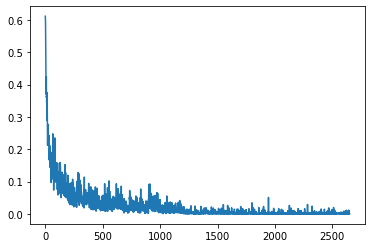

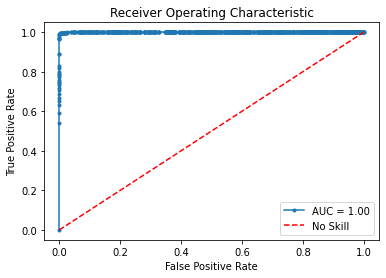

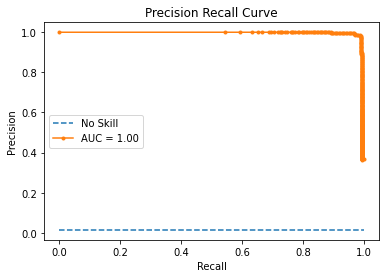

<Figure size 432x288 with 0 Axes>

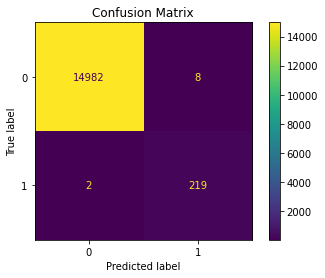

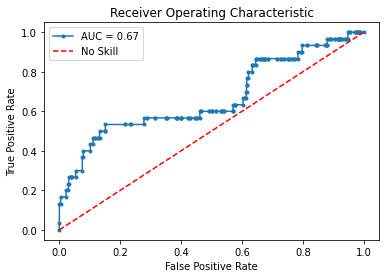

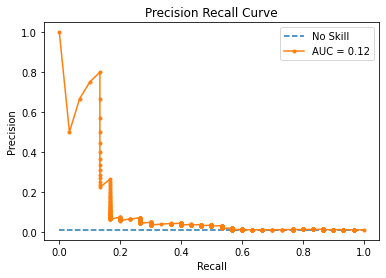

<Figure size 432x288 with 0 Axes>

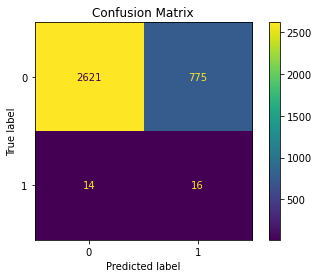

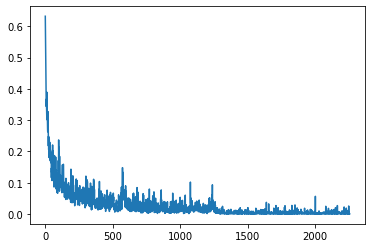

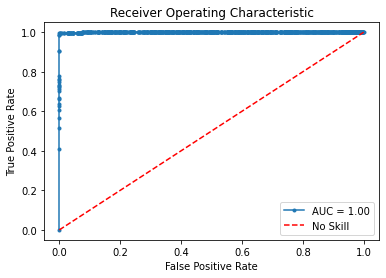

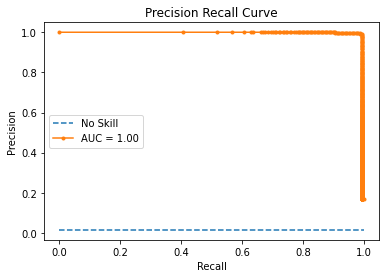

<Figure size 432x288 with 0 Axes>

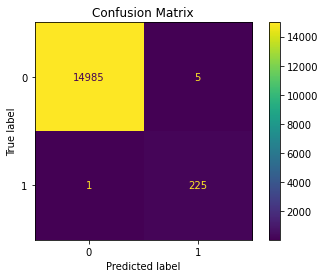

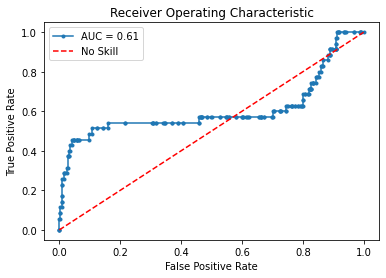

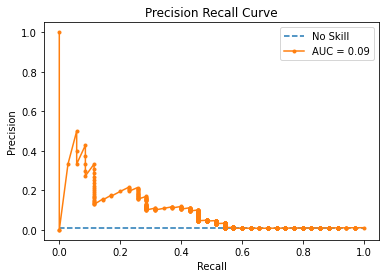

<Figure size 432x288 with 0 Axes>

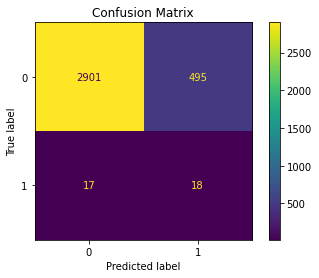

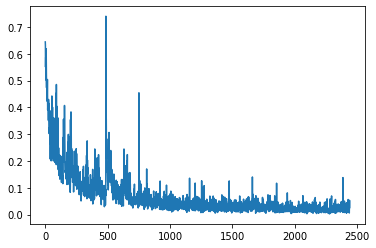

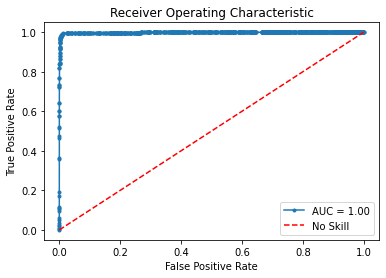

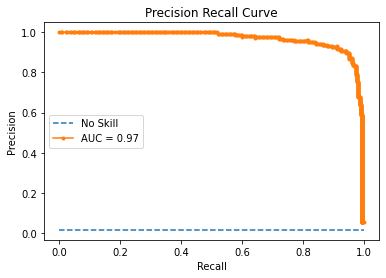

<Figure size 432x288 with 0 Axes>

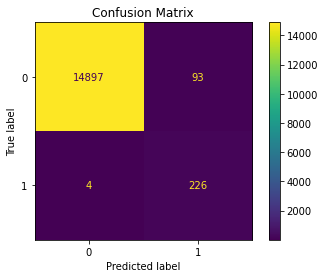

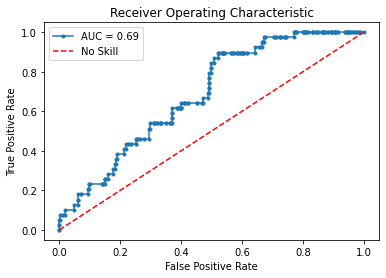

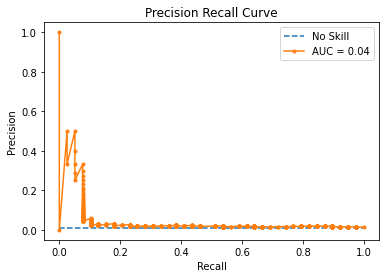

<Figure size 432x288 with 0 Axes>

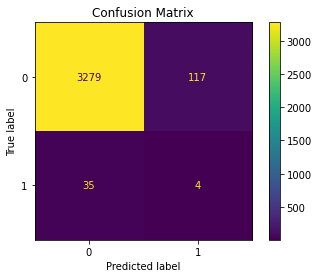

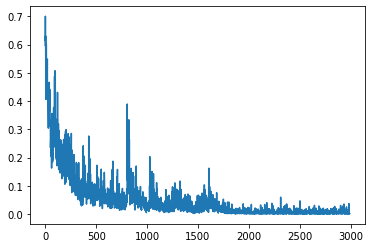

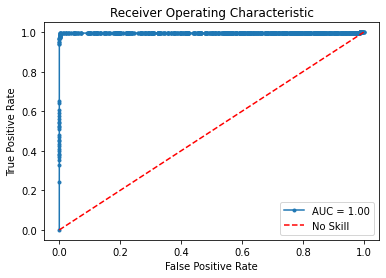

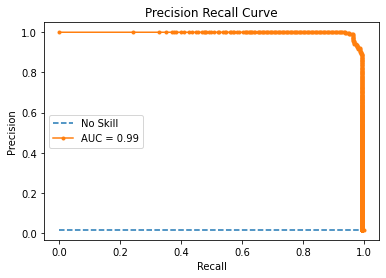

<Figure size 432x288 with 0 Axes>

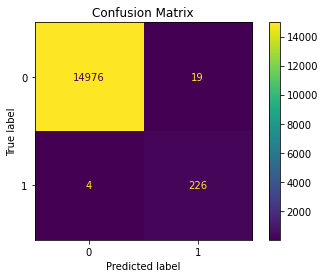

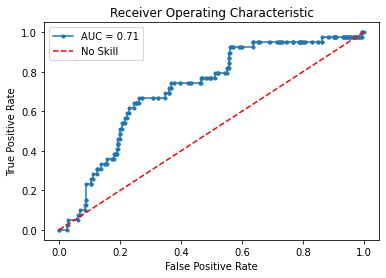

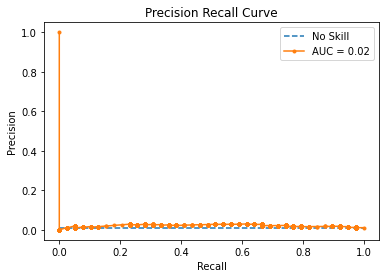

<Figure size 432x288 with 0 Axes>

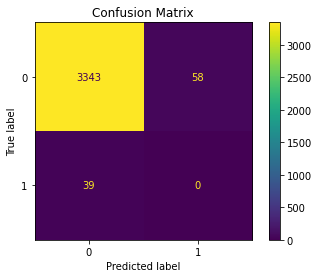

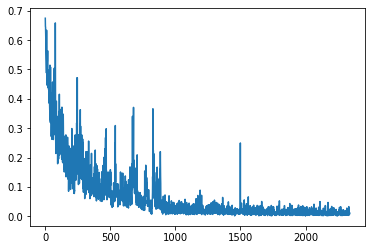

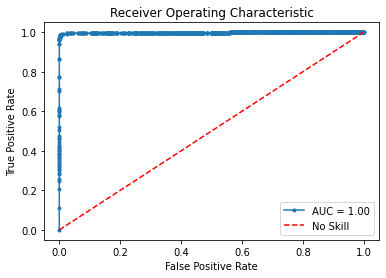

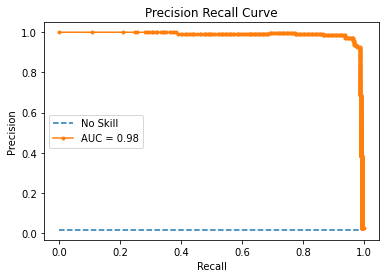

<Figure size 432x288 with 0 Axes>

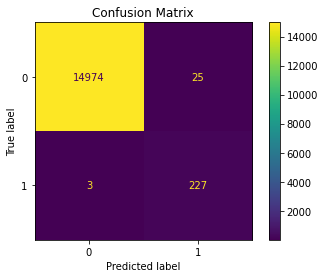

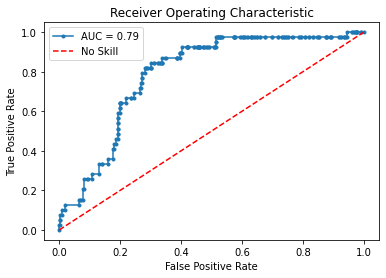

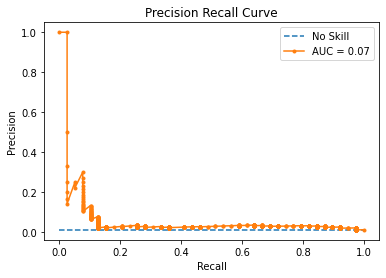

<Figure size 432x288 with 0 Axes>

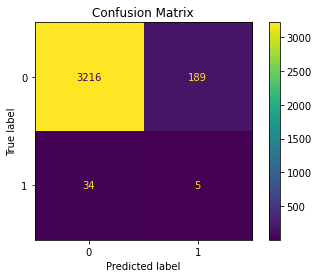

<Figure size 432x288 with 0 Axes>

time: 28min 57s (started: 2021-11-30 14:20:08 +00:00)


In [16]:
combinations = [
    [10, 10],
    [5, 10], 
    [1, 10], 
    [1, 5], 
    [1, 1]
]

# worksheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/1K15Rx4IZqiLgjUsmMq0blB-WB16MDY-ENR2j8z7S6Ss/edit#gid=0").sheet1

cols = [
  'DATE', 'CPU', 'CPU COUNT',	'GPU', 'GPU RAM',	'RAM',	'CUDA',	
  'REF', 'DATASET', 'ARCHITECTURE',	
  'SPLIT',	'TARGET',	'ACCURACY',	'ROC',	'PRC',
  'ROC_VALUES', 'PRC_VALUES',
  'TRAIN ROC',	'TRAIN PRC',	'EPISODES',	'TRAINING TIME'
]

load_from_saved = False

for comb in combinations:
  n_pos = comb[0]
  n_neg = comb[1]
  results = pd.DataFrame(columns=cols)
  print(f"\nRUNNING {n_pos}+/{n_neg}-")

  if load_from_saved:
    encoder = GCN(177, 128)
    lstm = ResiLSTMEmbedding(n_pos+n_neg)
    proto_net = ProtoNet()
    encoder.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt"))
    lstm.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt"))
    proto_net.load_state_dict(torch.load(f"{drive_path}/{method_dir}/{dataset}_proto_pos{n_pos}_neg{n_neg}.pt"))
    encoder.to(device)
    lstm.to(device)
    proto_net.to(device)

  else:
    encoder, lstm, proto_net, train_info = train(train_tasks, train_dfs, balanced_queries, n_pos, n_neg, n_query, episodes, lr)

    if with_bonds:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}_bonds.pt")
      torch.save(proto_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_proto_pos{n_pos}_neg{n_neg}_bonds.pt")
    else:
      torch.save(encoder.state_dict(), f"{drive_path}/{method_dir}/{dataset}_encoder_pos{n_pos}_neg{n_neg}.pt")
      torch.save(lstm.state_dict(), f"{drive_path}/{method_dir}/{dataset}_lstm_pos{n_pos}_neg{n_neg}.pt")
      torch.save(proto_net.state_dict(), f"{drive_path}/{method_dir}/{dataset}_proto_pos{n_pos}_neg{n_neg}.pt")
    
    loss_plot = plt.plot(train_info['losses'])[0]
    loss_plot.figure.savefig(f"{drive_path}/{method_dir}/loss_plots/{dataset}_pos{n_pos}_neg{n_neg}.png")
    plt.figure().clear()

  targets, preds, test_info = test(encoder, lstm, proto_net, test_tasks, test_dfs, n_pos, n_neg, test_rounds)

  dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  cpu = get_cmd_output('cat /proc/cpuinfo | grep -E "model name"')
  cpu = cpu.split('\n')[0].split('\t: ')[-1]
  cpu_count = psutil.cpu_count()
  cuda_version = get_cmd_output('nvcc --version | grep -E "Build"')
  gpu = get_cmd_output("nvidia-smi -L")
  general_ram_gb = humanize.naturalsize(psutil.virtual_memory().available)
  gpu_ram_total_mb = GPU.getGPUs()[0].memoryTotal

  for target in test_info:
    if load_from_saved:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'], 
                           test_info[target]['roc_values'], test_info[target]['prc_values'],
                          99, 99, 99, 102]], columns=cols)
  
      results = pd.concat([results, rec])
    else:
      rec = pd.DataFrame([[dt_string, cpu, cpu_count, gpu, gpu_ram_total_mb, general_ram_gb, cuda_version, "MSC", 
                          dataset, {method_dir}, f"{n_pos}+/{n_neg}-", target, 0, test_info[target]['roc'], test_info[target]['prc'],
                           test_info[target]['roc_values'], test_info[target]['prc_values'],
                          train_info["train_roc"], train_info["train_prc"], train_info["episodes"], train_info["duration"]
            ]], columns=cols)
  
      results = pd.concat([results, rec])

  if load_from_saved:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}_from_saved.csv", index=False)
  else:
    results.to_csv(f"{drive_path}/results/{dataset}_{method_dir}_pos{n_pos}_neg{n_neg}.csv", index=False)